# 1.- Importar las librerias

Primero es necesario importar algunas librerías que nos proporcionaran métodos o funciones para construir el modelo de un árbol de decisión, así como extraer y manipular sus reglas de asociación.

Las principales son ***pandas*** y ***numpy***, que se utilizan para todo el preprocesamiento de los datos; y todas las derivadas de ***sklearn***, que integra las herramientas de minería de datos a emplear.

Por último, se importan dos adicionales: ***sklearn2pmml***, una librería empleada para manejar modelos de minería de datos en formato PMML, y ***graphviz***, que simplemente nos brinda la posibilidad de graficar modelos de árboles de decisión, para una mejor visualización, presentación, análisis e interpretación.

In [1]:
#Se revisa la instalación adicional de graphviz y sklearn2pmml, ya que no viene incluida en el núcleo de python/anaconda
!pip install graphviz
!pip install sklearn2pmml

#Estructuras y análisis de datos
import pandas as pd
#Funciones matemáticas para vectores y matrices
import numpy as np

#Herramientas de minería de datos
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree.export import export_text

#Manejo de modelos vía PMML
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

#Graficar árboles de decisión
import graphviz

# 2.- Desarrollo: Proceso KDD

## 2.1.- Carga de la base de datos

La base de datos a utilizar tiene como nombres *cars.csv*, para más información al respecto, se puede consultar el diccionario de datos ubicado en el reporte de KNIME.
Utilizamos el método de pandas llamado **read_csv()**, que recibe como parámetro el nombre del archivo csv, que debe estar ubicado en el mismo directorio de este notebook.
Para visualizar los primeros registros de la base de datos, se utiliza el método **head()**.

In [2]:
carsCSV = pd.read_csv("cars.csv")
carsCSV.head(20)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


### 2.1.1.- Información y descripción de los datos

In [3]:
carsCSV.info()
carsCSV.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying      1728 non-null object
maint       1728 non-null object
doors       1728 non-null object
persons     1728 non-null object
lug_boot    1728 non-null object
safety      1728 non-null object
class       1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,high,high,5more,more,big,high,unacc
freq,432,432,432,576,576,576,1210


## 2.2.- Limpieza de datos

Si revisamos la existencia de datos nulos con el método **isnull().sum()**, notaremos que no los hay, por lo que no es necesario hacer una limpieza en la base de datos.

In [4]:
carsCSV.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

## 2.3.- Integración y selección de los datos

Solo nos basta con la base de datos principal *cars.csv*.
Se utilizarán todos los atributos disponibles en la base de datos, así como todos sus registros, por lo que no es necesario hacer alguna selección ni integración adicional específica.

## 2.4.- Transformación de los datos

Para la construcción de árboles de decisión que proporciona ***scikit learn***, no estan admitidos los registros cuyos tipo de datos sean distintos a números enteros.
Es necesario mapear y/o codificar los valores de todos los atributos de la base de datos con números.
Primero se crean los diccionarios correspondientes a cada atributo, que incluye el valor actual junto a su código respectivo, y luego se utiliza el método **map()** para reemplazar todos los valores de cada atributo.

In [5]:
#Lista que se utilizará para far formato al árbol de decisión
cars_feature_names = ["buying", "maint", "doors", "persons", "lug_boot","safety"]

cod = {"low":1, "med":2, "high":3, "vhigh":4} #para buying y maint
safety_cod = {"low":1, "med":2, "high":3} #para safety
lug_boot_cod = {"small":1, "med":2, "big":3} #para lug_boot
class_cod = {"unacc":1, "acc":2, "good":3, "vgood":4} #para class
doors_cod = {"1":1, "2":2, "3":3, "4":4, "5more":5} #para doors
persons_cod = {"2":1, "4":2, "more":3} #para persons

#Mapeo de datos
carsCSV["buying"] = carsCSV["buying"].map(cod)
carsCSV["maint"] = carsCSV["maint"].map(cod)
carsCSV["safety"] = carsCSV["safety"].map(safety_cod)
carsCSV["lug_boot"] = carsCSV["lug_boot"].map(lug_boot_cod)
carsCSV["class"] = carsCSV["class"].map(class_cod)
carsCSV["doors"] = carsCSV["doors"].map(doors_cod)
carsCSV["persons"] = carsCSV["persons"].map(persons_cod)
carsCSV.info()
carsCSV.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying      1728 non-null int64
maint       1728 non-null int64
doors       1728 non-null int64
persons     1728 non-null int64
lug_boot    1728 non-null int64
safety      1728 non-null int64
class       1728 non-null int64
dtypes: int64(7)
memory usage: 94.6 KB


,buying,maint,doors,persons,lug_boot,safety,class
0,4,4,2,1,1,1,1
1,4,4,2,1,1,2,1
2,4,4,2,1,1,3,1
3,4,4,2,1,2,1,1
4,4,4,2,1,2,2,1
5,4,4,2,1,2,3,1
6,4,4,2,1,3,1,1
7,4,4,2,1,3,2,1
8,4,4,2,1,3,3,1
9,4,4,2,2,1,1,1


Ahora el tipo de dato de todos los atributos es entero, y esto se puede comprobar al revisar la tabla de la base de datos resultante del mapeo.

# 3.- Minería de datos

## 3.1.- Partición de los datos

Al ser los árboles de decisiones algoritmos de aprendizaje supervisados, es necesario dividir el conjunto de datos para generar el modelo. Una parte será para el entrenamiento o aprendizaje, que será el 80% de todos los datos. La otra parte servirá para ser evaluada por el árbol de predicción, que por el momento no será utilizada en ésta práctica (esta parte corresponde al 20% restante).

La librería de ***scikit learn*** nos proporciona un método que se encarga de particionar los datos, de forma balanceada y aleatoria, para evitar problemas y complicaciones que pudiesen surgir de un particionamiento manual.

Para los valores en x, eliminamos la columna **class**, ya que los valores en y serán los datos de éste atributo.
Utilizando el método **train_test_split**, que recibe como parámetros los valores x, los valores x, el tamaño del conjunto de entrenamiento (0.8 = 80%), y una semilla aleatoria, seleccionamos aleatoriamente los mejores datos para entrenar al árbol de aprendizaje:



In [6]:
X_values = carsCSV.iloc[:,:6]
Y_values = carsCSV["class"]
x_train, x_test, y_train, y_test= train_test_split(X_values, Y_values, train_size=0.8, random_state=0)
x_train.head(20)

,buying,maint,doors,persons,lug_boot,safety
1649,1,1,3,1,1,3
1465,1,3,4,1,3,2
361,4,1,3,2,1,2
315,4,2,5,3,1,1
1372,1,4,4,3,2,2
170,4,3,4,1,3,3
762,3,1,2,1,3,1
1720,1,1,5,3,1,2
820,3,1,4,2,1,2
1433,1,3,3,1,1,3


In [7]:
y_train.head(20)

1649    1
1465    1
361     1
315     1
1372    2
170     1
762     1
1720    2
820     1
1433    1
1244    1
863     2
22      1
1501    2
45      1
632     2
651     1
61      1
1262    3
1484    4
Name: class, dtype: int64

## 3.2.- Árbol de decisión: aprendizaje

Es necesario entrenar al árbol de aprendizaje con el conjunto de datos obtenido en el paso anterior (particionamiento 80%), que posteriormente, podrá ser usado como referencia para clasificar nuevos datos entrantes desconocidos.

In [8]:
modelo = tree.DecisionTreeClassifier()
modelo = modelo.fit(x_train, y_train)

### 3.2.1.- Visualización del árbol

El árbol de decisión generado es el siguiente:

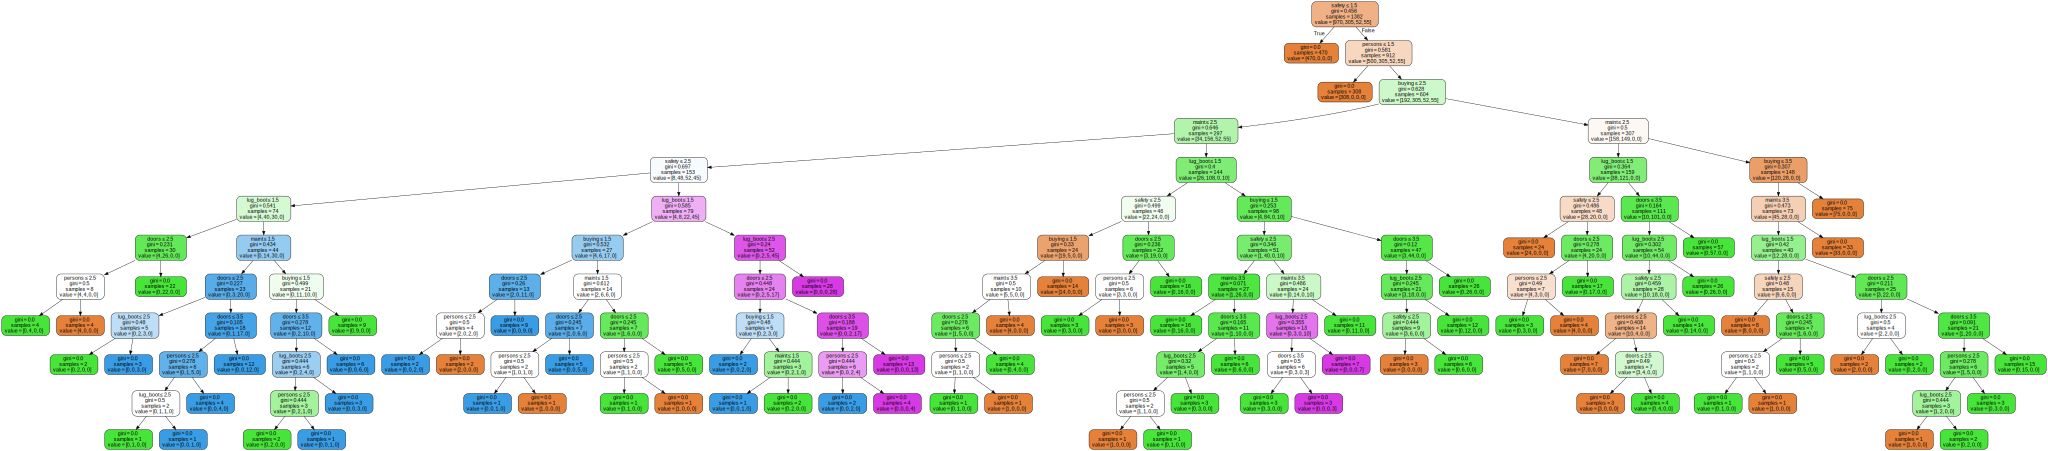

In [9]:
export_graphviz(modelo, out_file="cars_tree.dot", filled=True, rounded=True, special_characters=True,
               feature_names = cars_feature_names)

with open("cars_tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

## 3.3.- Reglas de clasificación

Las reglas de clasificación de un árbol simplemente son la representación en texto del modelo obtenido.
Se obtienen con ayuda del método **export_text()**, que recibe como parametros el modelo del árbol de decisión y una lista que posee el nombre de los atributos.

In [10]:
print(export_text(modelo, feature_names=cars_feature_names))

|--- safety <= 1.50
|   |--- class: 1
|--- safety >  1.50
|   |--- persons <= 1.50
|   |   |--- class: 1
|   |--- persons >  1.50
|   |   |--- buying <= 2.50
|   |   |   |--- maint <= 2.50
|   |   |   |   |--- safety <= 2.50
|   |   |   |   |   |--- lug_boot <= 1.50
|   |   |   |   |   |   |--- doors <= 2.50
|   |   |   |   |   |   |   |--- persons <= 2.50
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- persons >  2.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- doors >  2.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- lug_boot >  1.50
|   |   |   |   |   |   |--- maint <= 1.50
|   |   |   |   |   |   |   |--- doors <= 2.50
|   |   |   |   |   |   |   |   |--- lug_boot <= 2.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- lug_boot >  2.50
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- doors >  2.50
|   |   |   |   |   |   |   

## 3.4.- Importar reglas de clasificación a sentencia SQL

Obtener una sentencia SQL a partir del modelo representado por las reglas de clasificación del árbol de decisión generado es de gran ayuda cuando se tenga la base de datos cargada en un gestor de base de datos, como MySQL, y querramos hacer consultas para obtener registros que cumplan una serie de condiciones, logrando clasificándolos en el proceso.

Utilizando la API **sklearn2sql**, disponible por medio de un servidor heroku, convertimos el modelo del árbol de decisión generado a bytes, lo insertamos a un JSON y se envia como petición al servidor, obteniendo como respuesta la sentencia SQL.

Cabe aclarar que ésta herramienta aún esta en desarrollo, por lo que no es posible personalizar la sentencia SQL, como por ejemplo asignar el nombre de los atributos, asíe que el servidor los asigna por defecto.

In [11]:
import pickle, json, requests, base64

# Convertir el objeto árbol (modelo) a bytes, para posteriormente insertarlo en un JSON
b64_data = base64.b64encode(pickle.dumps(modelo)).decode('utf-8')
# Enviar el modelo como petición al servidor web
json_data = {"Name":"model1", "PickleData":b64_data , "SQLDialect":"mysql"}
r = requests.post("https://sklearn2sql.herokuapp.com/model", json = json_data)
#Obtener la respuesta
content = r.json()
lSQL = content["model"]["SQLGenrationResult"][0]["SQL"]
print(lSQL);

WITH `DT_node_lookup` AS 
(SELECT `ADS`.`KEY` AS `KEY`, CASE WHEN (`ADS`.`Feature_5` <= 1.5) THEN 1 ELSE CASE WHEN (`ADS`.`Feature_3` <= 1.5) THEN 3 ELSE CASE WHEN (`ADS`.`Feature_0` <= 2.5) THEN CASE WHEN (`ADS`.`Feature_1` <= 2.5) THEN CASE WHEN (`ADS`.`Feature_5` <= 2.5) THEN CASE WHEN (`ADS`.`Feature_4` <= 1.5) THEN CASE WHEN (`ADS`.`Feature_2` <= 2.5) THEN CASE WHEN (`ADS`.`Feature_3` <= 2.5) THEN 10 ELSE 11 END ELSE 12 END ELSE CASE WHEN (`ADS`.`Feature_1` <= 1.5) THEN CASE WHEN (`ADS`.`Feature_2` <= 2.5) THEN CASE WHEN (`ADS`.`Feature_4` <= 2.5) THEN 16 ELSE 17 END ELSE CASE WHEN (`ADS`.`Feature_2` <= 3.5) THEN CASE WHEN (`ADS`.`Feature_3` <= 2.5) THEN CASE WHEN (`ADS`.`Feature_4` <= 2.5) THEN 21 ELSE 22 END ELSE 23 END ELSE 24 END END ELSE CASE WHEN (`ADS`.`Feature_0` <= 1.5) THEN CASE WHEN (`ADS`.`Feature_2` <= 3.5) THEN CASE WHEN (`ADS`.`Feature_4` <= 2.5) THEN CASE WHEN (`ADS`.`Feature_3` <= 2.5) THEN 29 ELSE 30 END ELSE 31 END ELSE 32 END ELSE 33 END END END ELSE CASE WHEN 

## 3.5.- Importar reglas de clasificación a PMLL

Para guardar el modelo del árbol generado representado por sus reglas de decisión en un archivo PMML, primero creamos un pipeline que servirá como medio de comunicación entre el modelo guardado en memoria de la ejecución, y la escritura del archivo en disco duro.

Finalmente, invocamos al método **sklearn2pmml()**, que recibe como parámetros el pipeline y el nombre del archivo a escribir.

In [12]:
pipeline = PMMLPipeline([("cars_python", modelo)])
sklearn2pmml(pipeline, "cars_python.pmml")

 Cuando se requiera hacer una clasificación con otros datos de la base de datos, este archivo PMML es útil para no repetir todo el proceso para la creación del modelo de clasificación (árbol de decisión) descrito en este reporte desde el principio.

# 4.- Resultados encontrados

El atributo más significativo de toda la base de datos para determinar el estado de un automóvil es su **seguridad**, ya que si esta es baja o media, casi siempre el auto se clasificará en un estado inaceptable.
    
Por otro lado, el **precio de venta** y el **costo de mantenimiento** también juegan un papel importante. Si el precio de venta es bajo, pero el costo de mantenimiento es alto, el auto cae en clasificaciones de tipo aceptable o bueno, es decir, un estado intermedio que no es ni bueno ni malo. Si ambos atributos tienen costos muy altos, se clasificará como un auto no aceptable, a menos que tenga un tamaño grande **maletero**, un **número de puertas** mayor a 4, y/o una **capacidad de personas** de más de 5; si la **seguridad** esta en un rango medio alto, se puede clasificar incluso en un buen estado, a pesar de los altos costos. 
    
Los mejores autos son los que tengan un **costo de mantenimiento** y **precio de venta** medios, un **maletero** de gran tamaño, **capacidad para más de 4 personas**, y una **seguridad** alta.

# 5.- Bibliografía

https://scikit-learn.org/stable/

https://github.com/jpmml/sklearn2pmml

H. Sahu, S. Shrma y S. Gondhalakar, *A Brief Overview on Data Mining Survey*, International Journal of Computer Technology and Electronics Engineering (IJCTEE), vol. 1, no. 3, pp. 114 - 115, 2011